# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

In [24]:
import warnings
warnings.filterwarnings('ignore')

import os, csv, pickle, shutil
import numpy as np
import pandas as pd
import statsmodels.api as sm

from datetime import date
from envs.env_gridsearch import kellycriterion
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df
from utils.rlmetrics import get_return, get_metrics
from utils.clearlogs import clear_logs
from envs.env_rl_restrict import PairTradingEnv
from params import *

from stable_baselines3 import PPO, A2C, DQN
import quantstats as qs

folder_path = f"result/rl-restrict-zscore/"
os.makedirs(folder_path, exist_ok=True)

Load data from `preliminaries.ipynb`

In [2]:
# Load from cointncorr pickle file
with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

df0 = dfs[0][dfs[0]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']==data[0][1]].reset_index(drop=True)

# Because we want to calculate profit based on BTC. Hence the price need to be changed.
df0 = df0[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df0['close'] = df0['close'].apply(lambda x: 1/x)

df1 = df1[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df1['close'] = df1['close'].apply(lambda x: 1/x)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [3]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

print(f"The length of our training data: {len(train0)}")

The length of our training data: 1331282


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [4]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1, noThres=True)
check_env(env)

## Do an experimental run with randomly generated actions

In [5]:
env = PairTradingEnv(train0, train1, tc=0, verbose=1, noThres=True, model=f"{folder_path}/networth_experiment.csv")
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

n_steps = 20

for step in range(n_steps):
    obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
    done = terminated or truncated
    env.render()
    if done:
        break

observation_space: Dict('position': Discrete(3), 'zscore': Box(-inf, inf, (1,), float64))
action_space: Discrete(4)
action_space.sample: 3
networth: 1.0, action: 2, position: 2, kc: 1 order_amount0: 20.634, order_amount1: -18.493000000000002 holding0: 20.634, holding1: -18.493000000000002 cash: 1.0, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
networth: 1.0, action: 1, position: 1, kc: 1 order_amount0: -20.634, order_amount1: 18.493000000000002 holding0: 0, holding1: 0 cash: 1.0, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
networth: 1.0, action: 1, position: 1, kc: 1 order_amount0: 0, order_amount1: 0 holding0: 0, holding1: 0 cash: 1.0, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
networth: 1.0, action: 2, position: 2, kc: 1 order_amount0: 20.634, order_amount1: -18.493000000000002 holding0: 20.634, holding1: -18.493000000000002 cash: 1.0, curr_price0: 0.004846370068818455, curr_price1: 0.005407451468123073 
ne

## Models from stable_baselines3

Delete existing tensorboard logs

In [23]:
log_path = f"logs/restrict_zscore/"
clear_logs(log_path)

Train with training data

In [7]:
'''PPO'''

env = PairTradingEnv(train0, train1, tc=0.002, noThres=True, model=f"{folder_path}/networth_ppo.csv")

model_ppo = PPO("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=500000)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [8]:
'''A2C'''

from stable_baselines3 import A2C

env = PairTradingEnv(train0, train1, tc=0.002, noThres=True, model=f"{folder_path}/networth_a2c.csv")

model_a2c = A2C("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=500000)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [9]:
'''DQN'''

from stable_baselines3 import DQN

env = PairTradingEnv(train0, train1, tc=0.002, noThres=True, model=f"{folder_path}/networth_dqn.csv")

model_dqn = DQN("MultiInputPolicy", env, verbose=0, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=500000)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

## Use the model on Test data

In [10]:
# del model_ppo, model_a2c, model_dqn

model_ppo = PPO.load(f"{folder_path}/ppo_pairtrading")
model_a2c = A2C.load(f"{folder_path}/a2c_pairtrading")
model_dqn = DQN.load(f"{folder_path}/dqn_pairtrading")

In [11]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, noThres=True, model=f"{folder_path}/networth_ppo.csv")
obs, _ = env.reset()

while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [12]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, noThres=True, model=f"{folder_path}/networth_a2c.csv")
obs, _ = env.reset()

while True:
    action, _states = model_a2c.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [13]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, noThres=True, model=f"{folder_path}/networth_dqn.csv")
obs, _ = env.reset()

while True:
    action, _states = model_dqn.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


### Analyze with Quanstats

In [14]:
os.remove(f"{folder_path}/networth_experiment.csv") if os.path.exists(f"{folder_path}/networth_experiment.csv") else None
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-11-30 23:59:59.999000', '0.9977404719502306']
The ending capital of networth_dqn.csv is ['2023-11-30 23:59:59.999000', '0.9863229895703113']
The ending capital of networth_ppo.csv is ['2023-11-30 23:59:59.999000', '1.0027946432808788']
The best model is networth_ppo.csv


In [15]:
best_return = get_return(f"{folder_path}/{best_model}")
get_metrics(best_return)

Compound annual growth rate: 0%
Total orders count: 469316
Total long action: 225795
Total short action: 224124
Won orders count: 225795
Lost orders count: 224124
Win/Loss order ratio: 1.0074556941692991
Avg order pnl: 7.973551830996413e-09
Avg order pnl won: 3.935869226809908e-05
Avg order pnl lost: -3.9635442010781156e-05
Avg long order pnl: -7.263841957763507e-06
Avg short order pnl: 6.801281455253636e-09


                    Strategy
------------------  ----------
Start Period        2023-01-01
End Period          2023-11-30
Risk-Free Rate      0.0%
Time in Market      96.0%

Cumulative Return   0.28%
CAGR﹪              0.21%

Sharpe              0.0
Prob. Sharpe Ratio  53.42%
Sortino             0.0
Sortino/√2          0.0
Omega               1.0

Max Drawdown        -1.9%
Longest DD Days     130

Gain/Pain Ratio     0.06
Gain/Pain (1M)      0.59

Payoff Ratio        0.99
Profit Factor       1.0
Common Sense Ratio  1.0
CPC Index           0.5
Tail Ratio          1.0
Outlier Win Ratio   4.58
Outlier Loss Ratio  4.2

MTD                 -0.1%
3M                  0.49%
6M                  0.13%
YTD                 0.28%
1Y                  0.28%
3Y (ann.)           0.21%
5Y (ann.)           0.21%
10Y (ann.)          0.21%
All-time (ann.)     0.21%

Avg. Drawdown       -0.07%
Avg. Drawdown Days  5
Recovery Factor     0.2
Ulcer Index         0.01
Serenity Index      0.0


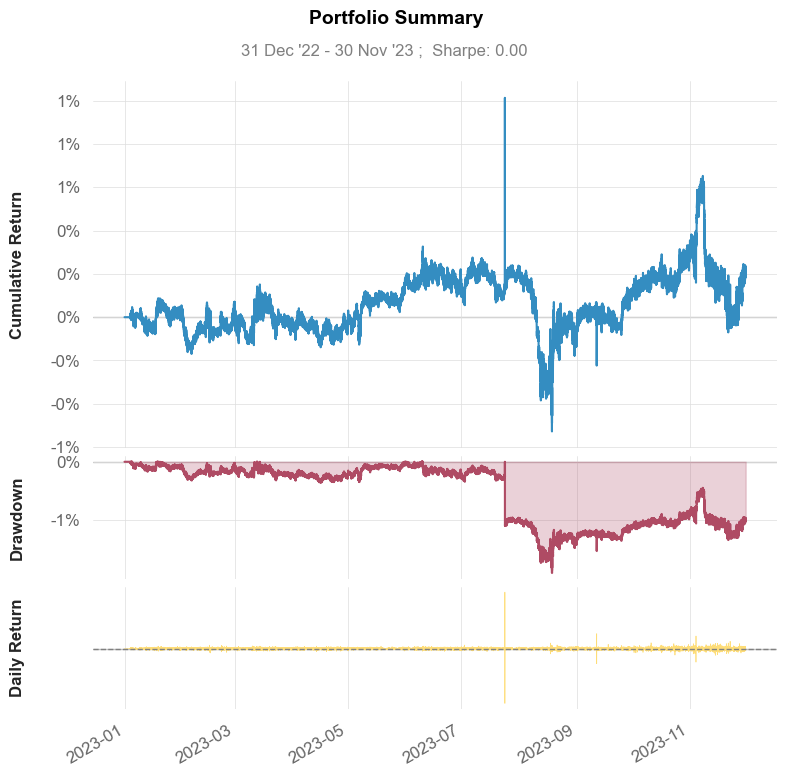

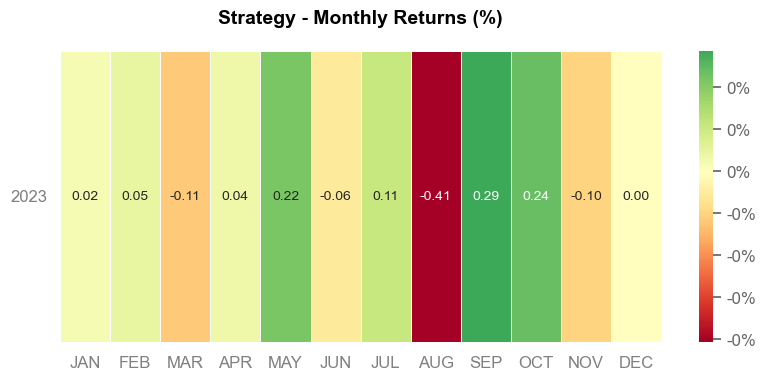

In [16]:
qs.reports.basic(best_return['returns'])